In [8]:
%run 'C:\Python jupyter\a_b\custom_score_card_func_v2.py'

ERROR:root:File `"'C:\\Python.py"` not found.


In [6]:
from dateutil.relativedelta import relativedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import Logit
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier

In [24]:
import pandas as pd

获取数据

In [9]:
data = pd.read_excel(r'C:\Python jupyter\a_b\a\LoanStats_2018Q3.xlsx')

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.Series(data.columns).to_clipboard()

删除部分字段，删除空行、重复行

In [11]:
#删除贷后字段
cols_after_loan=['sub_grade','grade','initial_list_status','out_prncp','out_prncp_inv',
                 'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
                 'total_rec_late_fee','recoveries','collection_recovery_fee',
                 'last_pymnt_d','last_pymnt_amnt','last_credit_pull_d',
                 'collections_12_mths_ex_med','policy_code','disbursement_method']
data=data.drop(columns=cols_after_loan)                 
#删除不便处理的字段，如职位、借款意图（事实上这两个字段包含很重要的信息.但不好处理）
cols_hard=['emp_title','title']
data=data.drop(columns=cols_hard)

In [12]:
#删除缺失率0.9+的字段
cols_null=[] 
for col_null in data.columns:
    if data[col_null].count() / data.shape[0] < 0.9:
        cols_null.append(col_null)
data=data.drop(columns=cols_null)

In [13]:
pd.Series(data.columns).to_clipboard()

In [14]:
#删除常量字段（字段某个取值占比大于95%）
#选取95%的原因：之后使用卡方分箱处理数据，分箱后的一个要求是单箱样本数占比大于等于5%；
cols_constant=[]
for col_constant in data.columns:
    if data[col_constant].value_counts(dropna=False,normalize=True).max()>0.95:
        cols_constant.append(col_constant)
data=data.drop(columns=cols_constant)

In [15]:
#删除空行，删除重复行
data=data.drop_duplicates().dropna(axis=0,how='all') 

In [16]:
data.head()
#一些变量需要进一步转换为便于处理的类型，特别是object，可能混合了多种数据类型

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies
0,1,5000,5000,4975.0,36 months,0.1065,162.87,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,860xx,AZ,27.65,0,1985-01-01,1.0,3.0,0.0,13648.0,0.837,9,0.0
1,2,2500,2500,2500.0,60 months,0.1527,59.83,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,309xx,GA,1.00,0,1999-04-01,5.0,3.0,0.0,1687.0,0.094,4,0.0
2,3,2400,2400,2400.0,36 months,0.1596,84.33,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,606xx,IL,8.72,0,2001-11-01,2.0,2.0,0.0,2956.0,0.985,10,0.0
3,4,10000,10000,10000.0,36 months,0.1349,339.31,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,917xx,CA,20.00,0,1996-02-01,1.0,10.0,0.0,5598.0,0.210,37,0.0
4,5,3000,3000,3000.0,60 months,0.1269,67.79,1 year,RENT,80000.0,Source Verified,2011-12-01,Fully Paid,other,972xx,OR,17.94,0,1996-01-01,0.0,15.0,0.0,27783.0,0.539,38,0.0


转换数据类型，暂不处理缺失、异常

In [ ]:
#申请评分卡开发所用数据的借款期限不宜过长，故在60期和36期中选用36期
data=data[data['term']==' 36 months']
data['term']=data.term.map(lambda x:int(x.replace(' months','')))
data['int_rate']=data.int_rate.map(lambda x:float(x.replace('%',''))/100)

In [57]:
#工作年限转换object类型为数值
def emp_length_num(x):
    if str(x)=='nan':return np.nan
    elif '< 1' in x:return 0
    elif x=='1 year':return 1
    elif '10+' in x:return 11
    else :return int(x.replace('years',''))
data['emp_length']=data.emp_length.map(lambda x:emp_length_num(x))

In [18]:
data['y']=data['loan_status'].map(lambda x : 0 if 'Fully Paid' in x else 1)#目标变量：坏样本标记1，好样本标记0

In [ ]:
#变量delinq_2yrs，过去两年逾期次数，当前数据类型object，理应为数值型；
#查看详情：set(data['delinq_2yrs'])；
#发现含有多种数据类型，且有个错误值'Jan-97'；将其数据类型处理为float，错误值空缺；
data['delinq_2yrs']=data['delinq_2yrs'].apply(pd.to_numeric,errors='coerce')

#变量revol_bal，所有信用卡可用余额，当前数据类型object，理应为数值型；
#查看详情：df1012=data['revol_bal'].map(lambda x:type(x).__name__)#每个元素映射为其数据类型；
#          set(df1012)#有int，str两种类型；
#查看数据类型为str的数据：data['revol_bal'][list(df1012[df1012=='str'].index)]#结果仍然是数值；
#故，判断该变量混合两种数据类型的原因是：部分数值以str格式出现，需要转换float；
#转换报错发现错误值'25.70%'，空缺代替；
data['revol_bal']=data['revol_bal'].apply(pd.to_numeric,errors='coerce')

#使用与处理变量revol_bal相似的方法，变量revol_util混合多种数据类型的详情及其处理方式：
#float：全为np.nan，维持；str：百分比形式的数值，转换为float数值
data['revol_util']=data['revol_util'].map(lambda x:float(x.replace('%',''))/100,na_action='ignore')

#使用与处理变量revol_bal相似的方法；变量total_acc混合多种数据类型的详情及其处理方式：
#int：转换float；float：含np.nan和数值，维持；str：含str格式的数值，转换为float数值，错误值'f'以no.nan代替；
data['total_acc']=data['total_acc'].apply(pd.to_numeric,errors='coerce')

#变量earliest_cr_line,issue_d：float全为np.nan；str为字符串格式的日期，转换为日期格式
data[['earliest_cr_line','issue_d']]=data[['earliest_cr_line','issue_d']].apply(pd.to_datetime)

使用现有变量构建新变量

In [20]:
#负债收入比
data['pnt_debt']=data.loan_amnt/data.annual_inc

In [21]:
#最早借款账户开立日到本次申请贷款的时间跨度，月计
def gap_months(late,early):
    if str(late)=='NaT' or str(early)=='NaT':return np.nan
    elif late<early:return 0
    else:
        gap=relativedelta(late,early)
        months=gap.years*12+gap.months
        return months
data['earliest_to_issue']=data.apply(lambda x:gap_months(x.issue_d,x.earliest_cr_line),axis=1)

图示数据分布：
离散变量：缺失；变量各取值下样本数、占总样本数比例；同一取值下好、坏样本占比；
连续变量：缺失；极端值；概率估计；

In [71]:
#离散变量
cols_discrete=['emp_length', 'home_ownership','verification_status','purpose', 
               'zip_code','addr_state']
#连续变量
cols_continue=['loan_amnt', 'funded_amnt', 'funded_amnt_inv','int_rate','installment',
              'annual_inc','dti','delinq_2yrs', 'inq_last_6mths', 'open_acc','pub_rec',
               'revol_bal', 'revol_util', 'total_acc','pub_rec_bankruptcies','pnt_debt',
               'earliest_to_issue']
#日期变量（已用于构建新变量，不再使用）
cols_date=['issue_d','earliest_cr_line']
#目标变量：'y'

In [9]:
#图示离散数据原始分布，可用于参照以处理缺失，调整卡方分箱结果
#以emp_length为例，横向条形图，nan：835——2.65%，表示变量emp_length下，空值样本835，占比约2.65%；
#横向堆积条形图：11:87.94%，12.06%，表示变量emp_length取值11下，好坏样本各占比87.94%、12.06%；
plot_discrete(data,cols_discrete,'y')

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 864x1728 with 12 Axes>

In [10]:
#图示连续数据原始分布，可用于参照以处理缺失，调整卡方分箱结果
#以变量loan_amnt为例，从左到右，依次为箱线图、按目标变量y取值分组分别绘制箱线图、直方图+核密度估计图、
#按目标变量y取值分组分别绘直方图+核密度估计图
plot_continue(data,cols_continue,'y')

<Figure size 864x5184 with 72 Axes>

In [31]:
#变量缺失概览，只显示有缺失的变量
view_null(data,cols=cols_discrete+cols_continue)

,NullOrNot,CntNotNull,CntNull,PntNull
pub_rec_bankruptcies,True,30169.0,1365.0,0.043287
emp_length,True,30699.0,835.0,0.026479
revol_util,True,31448.0,86.0,0.002727
delinq_2yrs,True,31505.0,29.0,0.000920
inq_last_6mths,True,31505.0,29.0,0.000920
open_acc,True,31505.0,29.0,0.000920
pub_rec,True,31505.0,29.0,0.000920
total_acc,True,31505.0,29.0,0.000920
earliest_to_issue,True,31505.0,29.0,0.000920
annual_inc,True,31530.0,4.0,0.000127


缺失异常处理

#### 之后的数据处理采用卡方分箱，其中一个要求是分箱后单箱占比大于等于5%；结合图示数据分布情况，在卡方分箱前，对缺失和异常进行如下处理：
（data.to_csv('view_null.csv')，保存为csv文件并下载到本地，以便于了解缺失、异常的详细情况）

样本异常：
索引为38040的样本，多个字段存在异常或缺失，删除；

离散变量缺失：
emp_length：众数补缺；

离散变量异常：未发现异常

连续变量缺失：
revol_bal：删除索引为38040的样本后，不再有缺失；

pub_rec_bankruptcies：缺失1365，占比约4.33%，接近5%，使用-1补缺，卡方分箱时作特殊值处理，单独一组；

revol_util：信用卡总额使用率，与revol_bal所有信用卡可用余额高度关联，revol_util缺失对应的revol_bal几乎都为0，

revol_bal为0对应的revol_util多数为0或缺失，故revol_util缺失用0填充；

annual_inc、pnt_debt：分布图示存在极端值，使用中位数补缺，相比均值补缺更合适；

delinq_2yrs、inq_last_6mths、open_acc、pub_rec、total_acc、earliest_to_issue：索引为38040的样本删除后，

这些变量缺失数量一致，且可判断相关缺失样本在这些字段同时出现缺失（判断代码未给出）；29个缺失中，26个为好样本，3个为坏样本；分布图示存在极端值；故这些变量使用各自好样本的非缺失值中位数填充；
    
连续变量异常：卡方分箱中处理；
'''

In [72]:
data=data.drop(index=38040)
data['pub_rec_bankruptcies']=data.pub_rec_bankruptcies.fillna(-1)
data['emp_length']=data.emp_length.fillna(data.emp_length.value_counts().sort_values(ascending=False).index[0])
data['revol_util']=data.revol_util.fillna(0)

In [73]:
val_fillna1=data[['pnt_debt','annual_inc']].median().to_dict()
data[['pnt_debt','annual_inc']]=data[['pnt_debt','annual_inc']].fillna(val_fillna1)

val_fillna2=data[['delinq_2yrs','inq_last_6mths','open_acc','earliest_to_issue',
                'pub_rec','total_acc']][data.y==0].median(axis=0).to_dict()
data[['delinq_2yrs','inq_last_6mths','open_acc','earliest_to_issue','pub_rec',
      'total_acc']]=data[['delinq_2yrs','inq_last_6mths','open_acc','earliest_to_issue',
                          'pub_rec','total_acc']].fillna(val_fillna2)

In [74]:
#连续变量异常处理
#上四分位数high_quantile，下四分位数low_quantile，四分位距iqr=high_quantile - low_quantile；
#异常与否的边界为：上边界thresh_high=high_quantile + 3*iqr ,下边界thresh_low=low_quantile - 3*iqr；
#处理：如果某个值为异常值，则令其等于最近边界；

#cols_not_handle内变量处理异常后，就变成了常量，故不处理
cols_not_handle=['pub_rec','delinq_2yrs','pub_rec_bankruptcies']
for col in cols_continue:
    if col in cols_not_handle:continue
    val_quantile=data[col].quantile([0.25,0.75]).to_dict()
    low_quantile=val_quantile[0.25];high_quantile=val_quantile[0.75]
    iqr=high_quantile - low_quantile
    thresh_low=low_quantile - 3*iqr;thresh_high=high_quantile + 3*iqr
    data[col]=data[col].map(lambda x:thresh_high if x>thresh_high else x)

In [75]:
data[cols_discrete+cols_continue].info()#缺失和异常处理完成

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31533 entries, 0 to 42534
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   emp_length            31533 non-null  float64
 1   home_ownership        31533 non-null  object 
 2   verification_status   31533 non-null  object 
 3   purpose               31533 non-null  object 
 4   zip_code              31533 non-null  object 
 5   addr_state            31533 non-null  object 
 6   loan_amnt             31533 non-null  float64
 7   funded_amnt           31533 non-null  float64
 8   funded_amnt_inv       31533 non-null  float64
 9   int_rate              31533 non-null  float64
 10  installment           31533 non-null  float64
 11  annual_inc            31533 non-null  float64
 12  dti                   31533 non-null  float64
 13  delinq_2yrs           31533 non-null  float64
 14  inq_last_6mths        31533 non-null  float64
 15  open_acc           

#### 卡方分箱：变量和参数

In [76]:
#分割数据为训练集、测试集:卡方分箱属于有监督分箱,故测试集不能与训练集一起处理,而是按训练集给出的规则分箱。
train_data,test_data=train_test_split(data,random_state=19,test_size=0.4,stratify=data.y)

#卡方分箱参数：
max_intervals=8#最大分箱数
min_pnt=0.05 #单箱样本数占样本总数最低比例

#卡方分箱变量：离散变量var_discrete，分为三部分：
#离散有序var_order、离散无序取值种类少var_discrete_less、离散无序取值种类多var_discrete_more；
#多与少的界限为最大分箱数max_intervals；
var_order=['emp_length']
var_discrete=list(set(cols_discrete)-set(var_order))
var_discrete_less=[]#取值种类数小于等于最大分箱数
var_discrete_more=[]#取值种类数大于最大分箱数
for var in var_discrete:
    if len(set(train_data[var])) <= max_intervals:var_discrete_less.append(var)
    else:var_discrete_more.append(var)
    
#卡方分箱变量：连续变量var_continue
var_continue=cols_continue.copy()

#### 卡方分箱：离散无序取值种类少变量、离散有序变量

In [ ]:
#离散有序变量取值根据期望有序性{变量取值：序值}(允许序值跳空)，构建新变量，并据此分组，分组完成后
#得{变量取值：组标记};参与分组的组标记为0起始的整数，若有不参与分组的取值，序值以负数表达，以避免
#与参与分组的组标记混淆；
emp_length_order={i:i for i in set(train_data['emp_length'])}#{变量取值：序值}
train_data['emp_length_order']=train_data['emp_length'].map(emp_length_order)

#name_var_order=[var+'_order']，离散有序变量名加'_order'后缀为新变量名；
#var_val_order={新变量名:{变量取值:序值}}；
#mono_discrete={新变量名:{'shape':期望单调性,'u':期望单调性不满足时是否允许U形}}，支持参数取值见函数monotone_badrate；
name_var_order=['emp_length_order']
var_val_order={'emp_length_order':emp_length_order}#用于更新分箱规则，始终为{变量原始取值:箱标记}
mono_discrete={'emp_length_order':{'shape':'mono','u':'u'}}

#调用针对离散变量取值种类少、离散有序变量的卡方分箱主函数bin_discrete，获取变量的woe编码规则、iv值、编码后变量名
woe_discrete,iv_discrete,var_discrete_woe=bin_discrete(train_data
                                                       ,var_discrete_less+name_var_order
                                                       ,y='y'
                                                       ,special_val={}
                                                       ,intervals_max=max_intervals
                                                       ,min_pnt=min_pnt
                                                       ,discrete_order=var_val_order
                                                       ,mono_except=mono_discrete
                                                       ,print_process=False)


#### 输出内容解释：

{原始取值：最新箱标记}
{'NONE': 0, 'OWN': 1, 'MORTGAGE': 0, 'OTHER': 3, 'RENT': 2}：字典键始终为变量原始取值，字典值为变量取值分组后的最新组标记。像变量verification始终各个取值为一组，不曾改变过，那么它的组标记始终为原始取值；
    而变量home_ownership因其分组改变过，改变后的组标记为0起始的数值,示例表示变量home_ownership的取值
    'NONE'和'MORTGAGE'被合并至一组，它们的组标记为0；
    
regroup：
索引：组标记，为变量原始取值或0起始的数值；
列：total——组样本总数；bad——组坏样本数；badrate——组坏样本率，bad/total；
    total_pnt——组样本占比,total除以所有组样本总数和；
    
相邻组卡方值：暂且称输出的列表为chis=[chi(0,1),chi(1,2),...,chi(k,k+1),...,chi(n-1,n)]，chi(k,k+1)是
    相邻的第k、k+1组的卡方值。
    
{箱标记：woe}：表示以字典形式呈现，字典键为分组标记，字典值为该组的woe编码值；
{原始取值(或离散有序变量序值)：woe}：表示以字典形式呈现，字典键为变量原始取值或离散有序变量序值，字典值为
    该组的woe编码值；
'''

卡方分箱：离散无序取值种类多变量，坏样本率编码后作连续变量处理

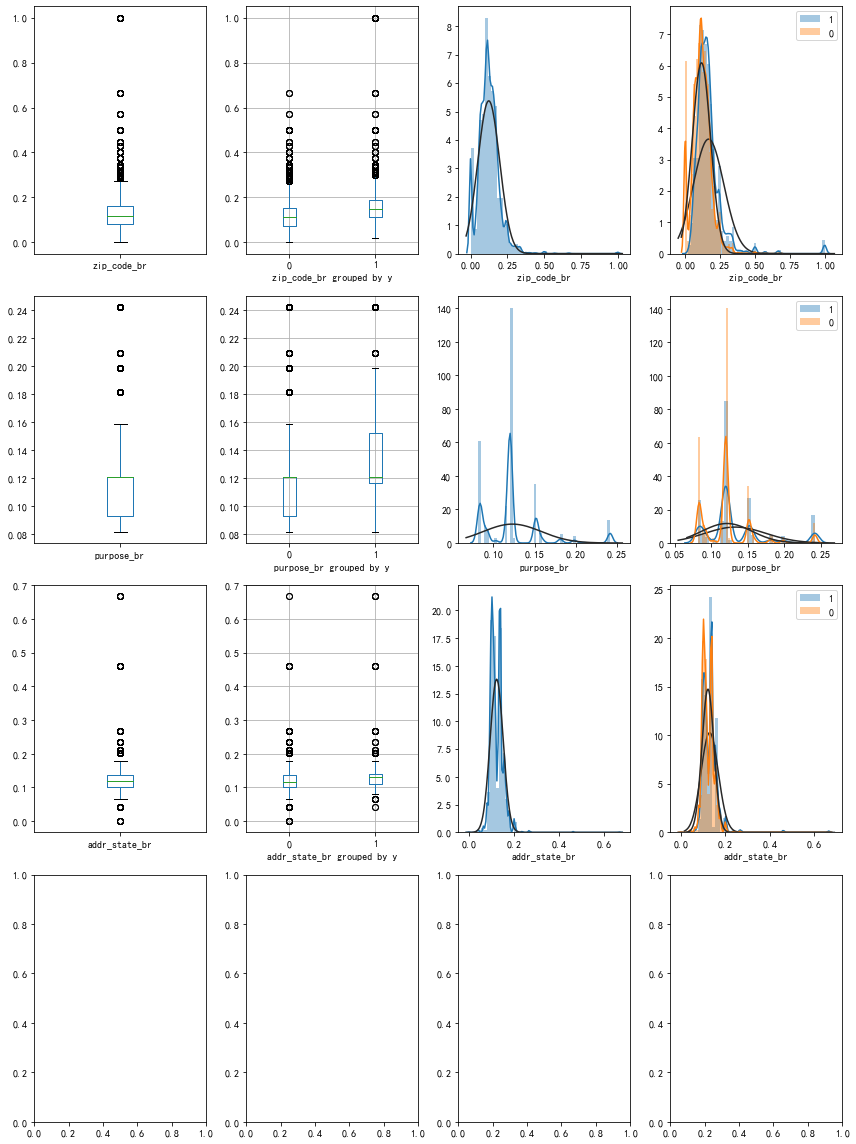

In [78]:
encode_discrete={}
for var in var_discrete_more:
    br_encode=bin_badrate(train_data,var,'y').badrate.to_dict()
    train_data[var+'_br']=train_data[var].map(br_encode)
    encode_discrete[var]=br_encode
    var_continue.append(var+'_br')
#图示分布
var_discrete_encode=[i+'_br' for i in var_discrete_more]
plot_continue(train_data,var_discrete_encode,'y')
#无缺失；存在异常值，卡方分箱处理

#### 卡方分箱：连续变量

In [79]:
special_val_contin={'pub_rec_bankruptcies':[-1]}#变量不参与分箱的特殊值
mono_contin={i:{'shape':'mono','u':'u'} for i in var_continue}#期望单调性
#调用针对连续变量的卡方分箱主函数bin_continue，获取变量的woe编码规则、iv值、编码后变量名
woe_contin,iv_contin,var_contin_woe=bin_continue(train_data
                                                 ,var_continue
                                                 ,y='y'
                                                 ,special_val=special_val_contin
                                                 ,intervals_max=max_intervals
                                                 ,min_pnt=min_pnt
                                                 ,mono_except=mono_contin
                                                 ,print_process=False)


变量：pub_rec_bankruptcies，不参与分组的取值单独自组，存在组样本数占比小于期望最低比例 0.05 ，未调整。
                      total  bad   badrate  total_pnt
pub_rec_bankruptcies                                 
-1.0                    817  197  0.241126   0.043184


#### 输出内容解释：以变量loan_amnt为例，
‘变量：loan_amnt_badrate；当前环节：组内坏样本率为0或1检查’：实际是变量loan_amnt，因所处环节不同，而添加
    不同的后缀，若是处于组样本总数检查环节，则为loan_amnt_min_pnt，由变量loan_amnt添加后缀'_min_pnt'得到；
‘regroup‘：
    索引名，loan_amnt_badrate，变量名后加上标识当前所处环节的后缀；
    索引，也是组标记，数值型数据，是分组后各组的上边界；其中一个特殊的上边界 1.000000e+11，通常变量取值
        不会这么大，它存在的意义：当该变量取值下有大于最大上边界的值时，可以正常分组；
    列，total——组样本数，total_pnt——某组样本数占所有组样本总数的比例，bad——组坏样本数，badrate——组坏样本率；
‘相邻组卡方值’：暂且称输出的列表为chis=[chi(0,1),chi(1,2),...,chi(k,k+1),...,chi(n-1,n)]，
    chi(k,k+1)是相邻的第k、k+1组的卡方值。例如loan_amnt_badrate下，卡方值10.119810528328625，对应chi(2,3),
    也就是第二、三组的卡方值：(可通过卡方值计算函数chi验证)
                        total    bad    badrate
    loan_amnt_badrate
    5.000000e+03        1900     278    0.146316
    7.500000e+03        3282     380    0.115783
'''

整理分箱结果

In [88]:
#所有变量及其取值woe
woe=woe_discrete.copy()
woe.update(woe_contin)
#所有变量iv
iv=iv_discrete.copy()
iv.update(iv_contin)
#woe编码构建的新变量名
var_woe=var_discrete_woe+var_contin_woe
#训练集数据，含原始变量和woe编码变量
var_woe_del=[i.replace('_woe','').replace('_br','') for i in var_woe]
train_data_woe=train_data[var_woe_del+var_woe+['y']]

变量挑选，单变量分析：剔除iv值低于0.01的特征

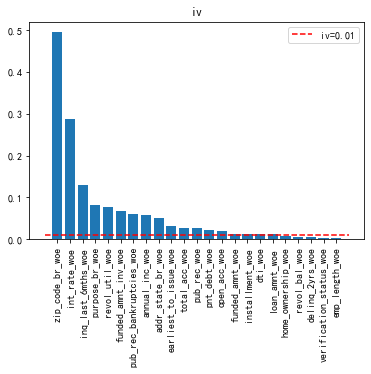

In [89]:
#图示iv
iv_sorted=sorted(iv.items(),key=lambda x:x[1],reverse=True)
iv_name=[i[0] for i in iv_sorted]
iv_val=[i[1] for i in iv_sorted]
iv_cnt=len(iv_val)
fig1231,ax1231=plt.subplots()
ax1231.bar(range(iv_cnt),iv_val)
ax1231set=ax1231.set(xticks=range(iv_cnt),xticklabels=iv_name,title='iv')
ax1231_xticks=plt.xticks(rotation=90)
#水平线：iv=0.01
ax1231.hlines(0.01,-1,len(iv_sorted),linestyle='--',color='r',label='iv=0.01')
ax1231.legend(loc='best')

In [93]:
#各个变量iv值都不高，故这里选取高于0.01的，条件允许，应提高iv筛选阈值
iv_high={k:v for k,v in iv.items() if v>=0.01}
iv_high_sorted=sorted(iv_high.items(),key=lambda x:x[1],reverse=True)
feat_iv_high=[i[0] for i in iv_high_sorted]

变量挑选，双变量分析：两个特征相关系数绝对值高于0.7，剔除iv值更低的征

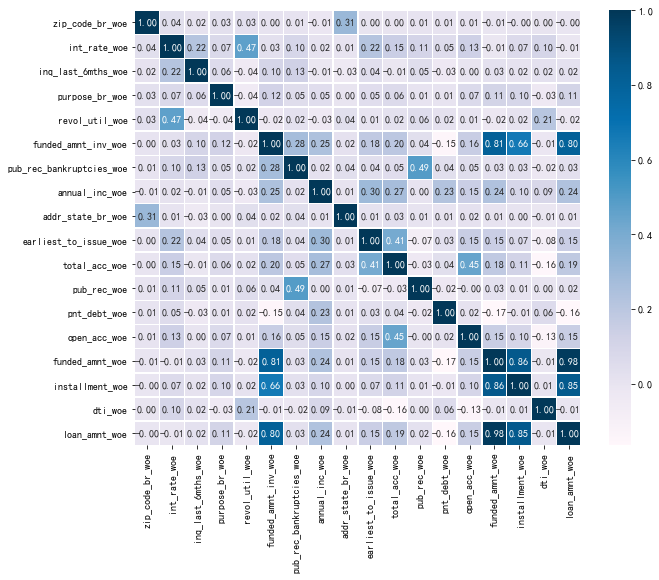

In [94]:
corr=train_data_woe[feat_iv_high].corr()
fig1025,ax1025=plt.subplots(figsize=(10,8))
sns.heatmap(corr,cmap='PuBu',ax=ax1025,annot=True,fmt='.2f',linewidth=0.5)

In [95]:
#检查变量两两间相关系数
cnt=len(iv_high)
id_del=[]
for i in range(cnt-1):
    for j in range(i+1,cnt):
        corr2=train_data_woe[[feat_iv_high[i],feat_iv_high[j]]].corr().iloc[0,1]
        if abs(corr2)>=0.7:
            if iv_high[feat_iv_high[i]]<=iv_high[feat_iv_high[j]]:id_del.append(i)
            else:id_del.append(j)
#feat_weak_corr内任意两个特征相关性绝对值小于0.7
feat_weak_corr=[feat_iv_high[i] for i in range(cnt) if i not in id_del]

变量挑选：排除多重共线性（vif>=10）

In [96]:
iv_feat_corr={i:iv_high[i] for i in feat_weak_corr}
feat_weakcorr_ivsorted=[i[0] for i in sorted(iv_feat_corr.items()
                                             ,key=lambda x:x[1]
                                             ,reverse=True)]

vif_matrix=np.matrix(train_data_woe[feat_weakcorr_ivsorted])
vifs=[variance_inflation_factor(vif_matrix,i) for i in range(vif_matrix.shape[1])]
print('max(vifs)=%s,所有vifs:\n\n%s'%(max(vifs),vifs))#max(vifs)<10，无多重共线性

max(vifs)=1.5799567474617409,所有vifs:

[1.1237089101858646, 1.5799567474617409, 1.1233001204877688, 1.037704265200552, 1.403959704475908, 1.3037023880637988, 1.5110869276845023, 1.3173420909090623, 1.117484746780714, 1.3530668070338916, 1.5378122850343292, 1.3840226373434803, 1.1367004108438328, 1.2869289436151747, 1.1178059694879632]


根据排除多重共线性后的特征，处理测试集

In [97]:
test_data=encode_new(test_data,feat_weakcorr_ivsorted
                     ,var_discrete_less,var_order
                     ,woe,train_data_woe
                     ,encode_discrete,var_continue)

离散取值种类多变量：zip_code，新数据集存在训练集未见取值，以badrate最大值编码


训练模型：Logit

In [98]:
#回归
feat_nocorr=feat_weakcorr_ivsorted.copy()#feat_weakcorr_ivsorted至此已排除具有明显多重共线性
x=train_data_woe[feat_nocorr]
x['intercept']=[1]*x.shape[0]
y=train_data_woe['y']
lr=Logit(y,x).fit()
lr.summary()

Optimization terminated successfully.
         Current function value: 0.324218
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                18919
Model:                          Logit   Df Residuals:                    18903
Method:                           MLE   Df Model:                           15
Date:                Wed, 08 Jul 2020   Pseudo R-squ.:                  0.1302
Time:                        20:28:14   Log-Likelihood:                -6133.9
converged:                       True   LL-Null:                       -7052.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
zip_code_br_woe              0.9747      0.045     21.583      0.000       0.886       1.063
int_rate_woe                 0.7204      0.056     12.948      0.000       0.611       0.829
inq_last_6mths_woe           0.7129      0.065     10.926      0.000       0.585       0.841
purpose_br_woe               0.7928      0.083      9.522      0.000       0.630       0.956
revol_util_woe               0.4819      0.095      5.062      0.000       0.295       0.668
funded_amnt_inv_woe          0.5750      0.101      5.671      0.000       0.376       0.774
pub_rec_bankruptcies_woe     0.3437      0.108      3.182      0.001       0.132       0.555
annual_inc_woe               0.6961      0.114      6.097      0.000       0.472       0.920
addr_state_br_woe            0.0587      0.109      0.539      0.590      -0.155       0.272
earliest_to_issue_woe        0.0306      0.146      0.210      0.834      -0.256       0.317
total_acc_woe                0.0964      0.173      0.559      0.576      -0.242       0.435
pub_rec_woe                  0.4174      0.153      2.725      0.006       0.117       0.718
pnt_debt_woe                 0.8746      0.158      5.537      0.000       0.565       1.184
open_acc_woe                 0.1052      0.186      0.566      0.572      -0.259       0.470
dti_woe                      0.3726      0.223      1.669      0.095      -0.065       0.810
intercept                   -1.9653      0.025    -78.541      0.000      -2.014      -1.916
============================================================================================
"""

In [99]:
#剔除不显著特征，取显著性水平0.1
feat_large_p={k:v for k,v in lr.pvalues.to_dict().items() if v>0.1}
feat_large_p=sorted(feat_large_p.items(),key=lambda x:x[1],reverse=True)
while len(feat_large_p)>0:
    feat_max_p=feat_large_p[0][0]
    print('不显著变量：%s，p>0.1'%feat_max_p)
    if feat_max_p=='intercept':print('intercept 不显著');continue
    feat_nocorr.remove(feat_max_p)
    x_p=train_data_woe[feat_nocorr]
    x_p['intercept']=[1]*x_p.shape[0]
    lr_p=Logit(y,x_p).fit()
    feat_large_p={k:v for k,v in lr_p.pvalues.to_dict().items() if v>0.1}
    feat_large_p=sorted(feat_large_p.items(),key=lambda x:x[1],reverse=True)

不显著变量：earliest_to_issue_woe，p>0.1
Optimization terminated successfully.
         Current function value: 0.324219
         Iterations 7
不显著变量：addr_state_br_woe，p>0.1
Optimization terminated successfully.
         Current function value: 0.324227
         Iterations 7
不显著变量：open_acc_woe，p>0.1
Optimization terminated successfully.
         Current function value: 0.324235
         Iterations 7
不显著变量：total_acc_woe，p>0.1
Optimization terminated successfully.
         Current function value: 0.324260
         Iterations 7
不显著变量：dti_woe，p>0.1
Optimization terminated successfully.
         Current function value: 0.324314
         Iterations 7


In [100]:
x_smallP=train_data_woe[feat_nocorr]
x_smallP['intercept']=[1]*x_smallP.shape[0]
lr_smallP=Logit(y,x_smallP).fit()
lr_smallP.summary()#所有特征p值都小于0.1，表示所有特征都显著；回归系数除截距外符号都ok

Optimization terminated successfully.
         Current function value: 0.324314
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                18919
Model:                          Logit   Df Residuals:                    18908
Method:                           MLE   Df Model:                           10
Date:                Wed, 08 Jul 2020   Pseudo R-squ.:                  0.1299
Time:                        20:28:40   Log-Likelihood:                -6135.7
converged:                       True   LL-Null:                       -7052.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
zip_code_br_woe              0.9839      0.043     22.951      0.000       0.900       1.068
int_rate_woe                 0.7330      0.054     13.690      0.000       0.628       0.838
inq_last_6mths_woe           0.7103      0.065     10.936      0.000       0.583       0.838
purpose_br_woe               0.7929      0.083      9.554      0.000       0.630       0.956
revol_util_woe               0.5046      0.093      5.411      0.000       0.322       0.687
funded_amnt_inv_woe          0.5896      0.100      5.892      0.000       0.393       0.786
pub_rec_bankruptcies_woe     0.3485      0.108      3.239      0.001       0.138       0.559
annual_inc_woe               0.7419      0.107      6.908      0.000       0.531       0.952
pub_rec_woe                  0.3996      0.151      2.638      0.008       0.103       0.697
pnt_debt_woe                 0.8766      0.158      5.551      0.000       0.567       1.186
intercept                   -1.9657      0.025    -78.549      0.000      -2.015      -1.917
============================================================================================
"""

In [101]:
#判断样本为正例（坏样本）的概率
train_data_woe['y_pred']=lr_smallP.predict(x_smallP)
#确定建模特征
feat_model=list(lr_smallP.params.index)
feat_model.remove('intercept')

概率转换分数：base_score=1000;pdo=200

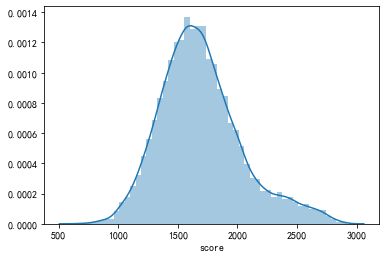

In [102]:
base_score=1000;pdo=200
train_data_woe['score']=train_data_woe['y_pred'].map(lambda x:proba_2score(x,base_score=base_score,pdo=pdo))
#分数分布概览：总体符合正态分布，稍左偏
sns.distplot(train_data_woe['score'])

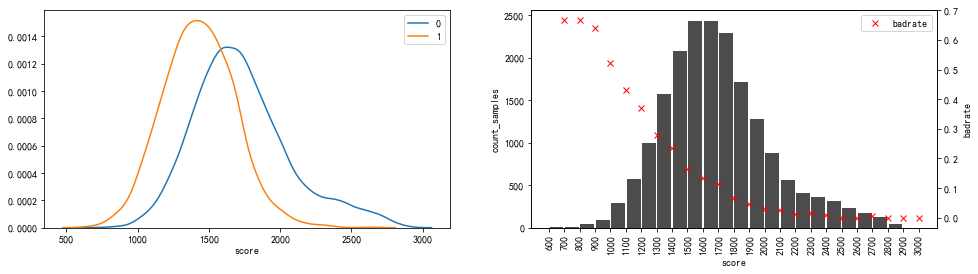

In [103]:
#重新切割分数区间以绘制直方图；绘制badrate随分数变化走势图
#好坏样本分别绘制分数分布曲线
bins1707=np.linspace(600,3000,num=25)#min=651，max=2921，600始，3000终，间隔100，切分24段
train_data_woe['bins']=pd.cut(train_data_woe['score'],bins1707)
regroup_bins=bin_badrate(train_data_woe,'bins','y')

fig1654,ax1654=plt.subplots(1,2,figsize=(8*2,4))
sns.distplot(train_data_woe['score'][train_data_woe.y==0],hist=False,ax=ax1654[0],label='0')
sns.distplot(train_data_woe['score'][train_data_woe.y==1],hist=False,ax=ax1654[0],label='1')
#分数直方图
ax1654[1].hist(train_data_woe['score'],bins=bins1707,rwidth=0.9,color='k',alpha=0.7)
ax1654set1=ax1654[1].set(xticks=bins1707,xlabel='score',ylabel='count_samples')
plt.xticks(rotation=90)
#badrate随分数变化图示(右y轴)
ax1655=ax1654[1].twinx()
ax1655.plot(bins1707[1:],list(regroup_bins.badrate),'rx',label='badrate')
ax1655set=ax1655.set(ylabel='badrate')
ax1655.legend(loc='best')
#分数总体呈正态分布，稍左偏，badrate整体随分数升高而下降
#（badrate在各分数区间上的单调性还受分数分段方式影响，可能存在局部不单调，当前切分24段，间隔100）

In [33]:
#分值分解：score=a - pdo/ln(2) * ln(p/(1-p))，其中 ln(p/(1-p)) = sum( wi*xi )，i=1,2,...,n，特征标记，
#令b=pdo/ln(2)，则有score=a-b*w0 - b*w1x1 - b*w2*x2 - ,...,- b*wnxn，即将总分score分解到各个变量取值x1,x2,...,xn；
#最后结果为{原始变量名：{原始取值：得分}}，以便于通过未编码原始取值及其得分，对比实际业务含义，判断编码评分合理性
coef=lr_smallP.params.to_dict()#变量系数（w）
woe_model={k:v for k,v in woe.items() if k in coef}#模型相关变量woe（x）
a=base_score;b=pdo/np.log(2)
var_val_score={}
for feat in woe_model:
    weight=coef[feat]
    var=feat.replace('_woe','')
    #离散取值种类多变量：原始取值—>badrate编码—>badrate编码分组上界—>woe编码值—>计算得分
    if var[-3:]=='_br':
        var=var.replace('_br','')
        thresh_badrate=sorted(list(woe_model[feat].keys()))
        val_badrate_thresh={k:refresh_val_2thresh(v,thresh_badrate) for k,v in encode_discrete[var].items()}
        val_score={k:-b*weight*woe[feat][v] for k,v in val_badrate_thresh.items()}
        var_val_score[var]=val_score
    #离散取值种类少、离散有序变量：原始取值—>woe编码值—>计算得分；
    #连续变量：原始取值—>原始取值分组上界—>woe编码值—>计算得分；
    #（原始取值映射到的分组上界仍然是原始取值的一部分，不像离散取值种类多变量badrate编码映射为完全不同的值，因此，）
    #（可以和离散取值种类少、离散有序变量相同方式处理，只是含义不同。）
    # else：var in var_discrete_less or var in var_order or var in var_continue:#var_continue含离散取值种类多变量，
    #但这类变量处理方式不同，故放在最前，并使用else，若用if，var_continue内会用错误方式处理后覆盖前面正确处理结果。
    else:
        val_score={k:-b*weight*x for k,x in woe_model[feat].items()}
        var_val_score[var]=val_score
var_val_score['intercept']={1:a-b*coef['intercept']}

In [34]:
#图示每个变量取值分数
fig1130,ax1130=plt.subplots(len(var_val_score),1,figsize=(10*1,4*len(var_val_score)))
i=0
for k in var_val_score:
    score=sorted(var_val_score[k].items(),key=lambda x:x[0])
    keys=[n[0] for n in score]
    values=[n[1] for n in score]
    xtick=list(range(len(keys)))
    ax1130[i].plot(xtick,values,'k--o')
    ax1130set=ax1130[i].set(xticks=xtick,xticklabels=keys,xlabel=k,ylabel='score')
    for x,y in zip(xtick,values):
        axtxt=ax1130[i].text(x,y+3,round(y,0),ha='center')
    ax1130[i].hlines(0,min(xtick),max(xtick),'r',linestyles='--',label='score=0')
    ax1130[i].legend(loc='best')
    i+=1
plt.tight_layout()

<Figure size 720x3168 with 11 Axes>

In [35]:
#对比验证概率计算得分总分，和分数拆解到变量取值再汇总得分——结果一致
score_detail=score_split(train_data_woe.iloc[:2],var_continue,var_val_score)#索引为35632、18552(32224、37755)
print('概率计算得分总分：\n',train_data_woe.iloc[:2]['score'])
print('\n分数拆解到变量取值再汇总得分：18552：%s，35632：%s'%(score_detail[35632]['total']['score'],
                                                               score_detail[18552]['total']['score']))

概率计算得分总分：
 35632    1715.935509
18552    1142.955048
Name: score, dtype: float64

分数拆解到变量取值再汇总得分：18552：1715.9355089560495，35632：1142.955047662569


模型评价：准确性、区分度、稳定性

In [36]:
#准确性：auc
auc_train=roc_auc_score(train_data_woe['y'],train_data_woe['y_pred'])
print('训练集准确性：auc_train：',auc_train)
#区分度：ks
ks_train=distin_ks(train_data_woe['y'],train_data_woe['y_pred'],plot_ks=True)
print('训练集区分度：ks=%s'%ks_train)
#区分度指标除了使用ks之外，还可以用divergence，gini（之后的程序中只用ks）
#区分度：divergence
diver=distin_divergence(train_data_woe['y'],train_data_woe['y_pred'])
print('训练集区分度，divergence=%s'%diver)
#区分度：gini
gini=distin_gini(train_data_woe['y'],train_data_woe['y_pred'],plot_gini=True)
print('训练集区分度：gini=%s'%gini)

训练集准确性：auc_train： 0.7568505848300044
训练集区分度：ks=0.3727572344396799
训练集区分度，divergence=0.7999397844057162
训练集区分度：gini=0.19942910099921457


<Figure size 432x288 with 1 Axes>

<Figure size 432x288 with 1 Axes>

测试数据

In [37]:
test_data['intercept']=[1]*test_data.shape[0]
test_data['y_pred']=lr_smallP.predict(test_data[feat_model+['intercept']])
test_data['score']=test_data['y_pred'].map(lambda x:proba_2score(x,base_score=base_score,pdo=pdo))

auc_test=roc_auc_score(test_data['y'],test_data['y_pred'])
print('测试集准确性：auc=%s'%auc_test)
ks_test=distin_ks(test_data['y'],test_data['y_pred'],plot_ks=True)
print('测试集区分度：ks=%s'%ks_test)
diver_test=distin_divergence(test_data['y'],test_data['y_pred'])
print('测试集区分度：diver=%s'%diver_test)
gini_test=distin_gini(test_data['y'],test_data['y_pred'],plot_gini=True)
print('测试集区分度：gini=%s'%gini_test)
psi_val=psi(train_data_woe.y,train_data_woe.y_pred,test_data.y,test_data.y_pred)
print('模型稳定性，训练集vs测试集：psi=%s'%psi_val)

测试集准确性：auc=0.652993929745994
测试集区分度：ks=0.2395766566370443
测试集区分度：diver=0.28042281780375955
测试集区分度：gini=0.20965708745178777
模型稳定性，训练集vs测试集：psi=0.0013205173609427067


<Figure size 432x288 with 1 Axes>

<Figure size 432x288 with 1 Axes>

尝试改善模型预测效果

数据准备

In [38]:
feat_ml = feat_weakcorr_ivsorted
# 训练集
x_train = train_data_woe[feat_ml]
y_train = train_data_woe['y']
# 测试集
x_test = test_data[feat_ml]
y_test = test_data['y']


卡方分箱、变量排除多重共线性、GBDT 默认参数

In [39]:
#gbdt默认参数训练模型
gbdt_init=GradientBoostingClassifier()
gbdt_init.fit(x_train,y_train)
#训练集，计算样本为正例的概率auc，ks
proba_train_gbdt_init=gbdt_init.predict_proba(x_train)[:,1]
auc_train_gbdt_init=roc_auc_score(y_train,proba_train_gbdt_init)
ks_train_gbdt_init=distin_ks(y_train,proba_train_gbdt_init)
print('训练集，gbdt+默认参数，auc=%s，ks=%s'%(auc_train_gbdt_init,ks_train_gbdt_init))
#测试集上，计算样本为正例的概率auc，ks
proba_test_gbdt_init=gbdt_init.predict_proba(x_test)[:,1]
auc_test_gbdt_init=roc_auc_score(y_test,proba_test_gbdt_init)
ks_test_gbdt_init=distin_ks(y_test,proba_test_gbdt_init)
print('测试集，gbdt+默认参数，auc=%s，ks=%s'%(auc_test_gbdt_init,ks_test_gbdt_init))
#psi,训练集vs测试集
psi_gbdt_init=psi(y_train,proba_train_gbdt_init,y_test,proba_test_gbdt_init)
print('psi,训练集vs测试集：%s'%psi_gbdt_init)

训练集，gbdt+默认参数，auc=0.7765948579566049，ks=0.39818562966627197
测试集，gbdt+默认参数，auc=0.651365428124927，ks=0.2372307746133931
psi,训练集vs测试集：0.0018204420433566577


重要性前n(n>=10)的变量、独热编码、GradientBoostingClassifier默认参数

In [40]:
var_discrete_gbdt=var_discrete_less+var_discrete_more#含离散无序取值种类少变量、离散取值种类多变量
var_continue_gbdt=var_continue+var_order#含离散有序变量、离散无序取值种类多已badrate编码变量、连续变量
train_data_gbdt=train_data[var_discrete_gbdt+var_continue_gbdt+['y']]
test_data_gbdt=test_data[var_discrete_gbdt+var_continue_gbdt+['y']]

#离散无序取值种类少变量badrate编码后作连续变量处理
for var in var_discrete_less:
    badrate_var=bin_badrate(train_data_gbdt,var,'y')['badrate'].to_dict()
    train_data_gbdt[var+'_br']=train_data_gbdt[var].map(badrate_var)
    test_data_gbdt[var+'_br']=test_data_gbdt[var].map(badrate_var)
    #测试集有，而训练集没有的取值，以最大badrate编码
    test_data_gbdt[var+'_br']=test_data_gbdt[var+'_br'].fillna(max(test_data_gbdt[var+'_br']))
    var_continue_gbdt.append(var+'_br')
    
#计算变量重要性并降排序
gbdt=GradientBoostingClassifier()
gbdt.fit(train_data_gbdt[var_continue_gbdt],train_data_gbdt.y)
feat_important=[(var,important) for var,important in zip(var_continue_gbdt,list(gbdt.feature_importances_))]
feat_important_sorted=sorted(feat_important,key=lambda x:x[1],reverse=True)

In [41]:
#选取重要性前n(n>=10)的变量建立模型
n_feats=list(range(10,len(feat_important_sorted)))
auc_train_list=[];auc_test_list=[];ks_train_list=[];ks_test_list=[];psi_list=[]

for n in n_feats:
    #准备数据
    feat_model_gbdt=[i[0] for i in feat_important_sorted[:n]]
    x_train_gbdt=train_data_gbdt[feat_model_gbdt];y_train_gbdt=train_data_gbdt['y']
    x_test_gbdt=test_data_gbdt[feat_model_gbdt];y_test_gbdt=test_data_gbdt['y']
    
    ####################################################################################################
    #badrate对离散无序变量编码，计算变量重要性；对重要性前n的离散变量（离散属性取值，而非badrate编码值）独热编码
    var_need_encode=[i.replace('_br','') for i in feat_model_gbdt if i[-3:]=='_br']
    #变量个数大于0存在需要独热编码的离散无序变量；等于0表示重要性前n的变量都为连续型，不用独热编码
    if len(var_need_encode)>0:
        feat_model_gbdt=[i for i in feat_model_gbdt if i[-3:]!='_br']#剩余连续变量
        #独热编码：训练集离散无序变量
        vect=DictVectorizer(sparse=False)
        var_discrete_onehot_train=vect.fit_transform(train_data_gbdt[var_need_encode].to_dict(orient='records'))
        x_train_gbdt=np.array(train_data_gbdt[feat_model_gbdt])
        x_train_gbdt=np.hstack([x_train_gbdt,var_discrete_onehot_train])
        #独热编码：测试集离散无序变量
        var_discrete_onehot_test=vect.transform(test_data_gbdt[var_need_encode].to_dict(orient='records'))
        x_test_gbdt=np.array(test_data_gbdt[feat_model_gbdt])
        x_test_gbdt=np.hstack([x_test_gbdt,var_discrete_onehot_test])
    ###################################################################################################
    
    #训练模型
    gbdt_important=GradientBoostingClassifier()#RandomForestClassifier()#
    gbdt_important.fit(x_train_gbdt,y_train_gbdt)
    
    #模型评价：训练集，auc、ks
    proba_train_gbdt_important=gbdt_important.predict_proba(x_train_gbdt)[:,1]
    auc_train_gbdt_important=roc_auc_score(y_train_gbdt,proba_train_gbdt_important)
    ks_train_gbdt_important=distin_ks(y_train_gbdt,proba_train_gbdt_important)
    #print('\n重要性前 %s 特征，训练集，auc=%s，ks=%s'%(n,auc_train_gbdt_important,ks_train_gbdt_important))
    
    #模型评价：测试集，auc、ks
    proba_test_gbdt_important=gbdt_important.predict_proba(x_test_gbdt)[:,1]
    auc_test_gbdt_important=roc_auc_score(y_test_gbdt,proba_test_gbdt_important)
    ks_test_gbdt_important=distin_ks(y_test_gbdt,proba_test_gbdt_important)
    #print('重要性前 %s 特征，测试集，auc=%s，ks=%s'%(n,auc_test_gbdt_important,ks_test_gbdt_important))
    
    #模型评价：psi（train vs test）
    psi_val=psi(y_train_gbdt,proba_train_gbdt_important,y_test_gbdt,proba_test_gbdt_important)
    #print('重要性前 %s 特征，训练集vs测试集，psi=%s'%(n,psi_val))
    
    #记录变量重要性前n(n>=10)的模型评价指标
    auc_train_list.append(auc_train_gbdt_important);auc_test_list.append(auc_test_gbdt_important);
    ks_train_list.append(ks_train_gbdt_important);ks_test_list.append(ks_test_gbdt_important);
    psi_list.append(psi_val)


In [42]:
#图示重要性前n个特征的GBDT预测效果
fig2158,ax2158=plt.subplots(1,3,figsize=(5*3,5*1))

#AUC
ax2158[0].plot(n_feats,auc_train_list,'k--o',label='train')
ax2158[0].plot(n_feats,auc_test_list,'r--x',label='test')
ax2158set0=ax2158[0].set(xticks=n_feats,xlabel='feat importance:front n',ylabel='AUC')
ax2158[0].legend(loc='best')
#AUC数据点注释
for i in range(0,len(n_feats),2):
    ax2158text00=ax2158[0].text(n_feats[i],auc_train_list[i]+0.005,round(auc_train_list[i],3),ha='center')
    ax2158text01=ax2158[0].text(n_feats[i],auc_test_list[i]+0.005,round(auc_test_list[i],3),ha='center')

#KS
ax2158[1].plot(n_feats,ks_train_list,'k--o',label='train')
ax2158[1].plot(n_feats,ks_test_list,'r--x',label='test')
ax2158set1=ax2158[1].set(xticks=n_feats,xlabel='feat importance:front n',ylabel='KS')
ax2158[1].legend(loc='best')
#KS数据点注释
for i in range(0,len(n_feats),2):
    ax2158text10=ax2158[1].text(n_feats[i],ks_train_list[i]+0.005,round(ks_train_list[i],3),ha='center')
    ax2158text11=ax2158[1].text(n_feats[i],ks_test_list[i]+0.005,round(ks_test_list[i],3),ha='center')

#PSI
ax2158[2].plot(n_feats,psi_list,'k--o')
ax2158set2=ax2158[2].set(xticks=n_feats,xlabel='feat importance:front n',ylabel='psi（train vs test）')
#PSI数据点注释
for i in range(0,len(n_feats),2):
    ax2158text2=ax2158[2].text(n_feats[i],psi_list[i]+0.001,round(psi_list[i],3),ha='center')
    
#调整子图布局
plt.tight_layout()

<Figure size 1080x360 with 3 Axes>